# Manuscript Draft

In this notebook, I generate all the figures and experiments needed for my first manuscript draft, to be submitted on November 1, 2025. I acknowledge heavy use of AI for coding these experiments and plots, which I carefully checked for correctness, though I did not improve code readability. 

Future work involves standarizing this notebook into a submission-ready file. It also involves cleaning up the GitHub repo thoroughly to avoid these issues...

In [1]:
# Packages
display("text/html", "<style>.container { width:100% !important; }</style>")

using Plots, LaTeXStrings, Distributions, DoubleFloats, Plots.PlotMeasures, LinearAlgebra,
    DataFrames, CSV, LsqFit, StatsBase, Distances, Parameters, Random, StatsBase, Graphs, GraphPlot,
    Base.Threads, Printf, HypothesisTests
Plots.theme(:dao)

include("../WagnerAlgorithm.jl")
using .BooleanNetwork
include("../DataProcessing.jl")
using .CustomStats

using ProgressMeter
using Base.Threads: Atomic, atomic_add!
using PyCall

py"""
import sys
import os
sys.path.append(os.path.abspath("../"))
from MotifSearch import *
"""

STANDARD_PARAMETERS = BooleanNetwork.STANDARD_PARAMETERS;


# Experiment 1 

Fitness and path length. Using the standard parameters, we get the population fitness and average path length of many of the simulation runs, and plot them per generation.

In [2]:
# Experiment 1

parameters = BooleanNetwork.STANDARD_PARAMETERS
parameters["G"] = 500
parameters["pop_size"] = 300
parameters["mode"] = "stable"

trials = 30 # 30
# Five noise levels: very low = 0.25, low = 1, medium = 2, high = 4, very high = 8
thetas = [0.25,1,2,4,8]

# Preparing different noise distribution levels
noise_dists = Vector{Any}(undef, 6)
noise_dists[1] = ("Noiseless", Bernoulli(1.0))
for (idx,θ) in enumerate(thetas)
    noise_dists[idx+1] = (θ, Gamma(1/θ, θ))    
end

n_total = length(noise_dists)
progress = Progress(n_total; desc="Running experiments...", barlen=4)
counter = Atomic{Int}(0)

dists_avgs_fit = Matrix{Float64}(undef, n_total, parameters["G"])
dists_avgs_path = similar(dists_avgs_fit)
dists_avgs_compl = similar(dists_avgs_fit)
dists_avgs_alignment = similar(dists_avgs_fit)
final_avg_alignments = Matrix{Float64}(undef,n_total, trials)
dists_sems_fit = similar(dists_avgs_fit)
dists_sems_path = similar(dists_avgs_fit)
dists_sems_compl = similar(dists_avgs_fit)
dists_sems_alignment = similar(dists_avgs_fit);


In [3]:
for idx_noise in 1:length(noise_dists)
    all_avgs_fit = Matrix{Float64}(undef, trials, parameters["G"])
    all_avgs_path = similar(all_avgs_fit)
    all_completions = similar(all_avgs_fit)
    all_avgs_alignment = similar(all_avgs_fit)

    Threads.@threads for idx_trial in 1:trials
        local_params = deepcopy(parameters)
        label_noise, noise_dist = noise_dists[idx_noise]
        local_params["noise_dist"] = noise_dist

        local_exp = BooleanNetwork.run_simulation(local_params)
        fitness_run = local_exp["fitness"]
        path_length_run = local_exp["path_length"]
        completion = local_exp["completion"]

        pop_alignments = CustomStats.compute_all_alignments(local_exp["matrices"], local_exp["phenotypic_optima"])

        avg_fit = mean(fitness_run, dims=2)  # mean per generation
        avg_path = [isempty(filter(!isnothing, row)) ? NaN :
                    mean(skipmissing(filter(!isnothing, row))) for row in eachrow(path_length_run)]
        avg_alignment = mean(pop_alignments, dims=2)

        all_avgs_fit[idx_trial, :] = avg_fit
        all_avgs_path[idx_trial, :] = avg_path
        all_completions[idx_trial, :] = completion
        all_avgs_alignment[idx_trial, :] = avg_alignment

        final_avg_alignments[idx_noise,idx_trial] = avg_alignment[end] # get the final alignment

    end

    dists_avgs_fit[idx_noise, :] = vec(mean(all_avgs_fit, dims=1))
    dists_avgs_path[idx_noise, :] = vec(mean(all_avgs_path, dims=1))
    dists_avgs_compl[idx_noise, :] = vec(mean(all_completions, dims=1))
    dists_avgs_alignment[idx_noise, :] = vec(mean(all_avgs_alignment, dims=1))
    dists_sems_fit[idx_noise, :] = vec(std(all_avgs_fit, dims=1) / sqrt(trials))
    dists_sems_path[idx_noise, :] = vec(std(all_avgs_path, dims=1) / sqrt(trials))
    dists_sems_compl[idx_noise, :] = vec(std(all_completions, dims=1) / sqrt(trials))
    dists_sems_alignment[idx_noise, :] = vec(std(all_avgs_alignment, dims=1) / sqrt(trials))

    atomic_add!(counter, 1)
    next!(progress)
end

Running experiments... 100%|████| Time: 0:12:15


In [4]:
"""
    plot_metric_many_trials(max_gens, noise_dists, metric_avgs, metric_sems; kwargs...)

Plots a metric over generations for multiple noise distributions, comparing them against
a "noiseless" control group.

This function is designed with a specific structure in mind:
1.  **"Noiseless" Control:** It assumes the first row (`noise_idx = 1`) of
    `metric_avgs` and `metric_sems` corresponds to a "noiseless" control.
    This line is plotted separately in black with a dotted style and a raw SEM ribbon.
2.  **"Noisy" Lines:** It plots all subsequent rows (`noise_idx >= 2`) as "noisy"
    trials.
3.  **Color Gradient:** The colors of the "noisy" lines are scaled according to their
    variance (the first element of each item in `noise_dists`), mapped to a
    `colorscheme`.
4.  **Error Ribbons:** The noisy lines are plotted with a 95% Confidence Interval
    ribbon (calculated as `SEM * 1.96`).
5.  **Legend:** To avoid clutter, only the "Noiseless" line and the first "Noisy"
    line (`noise_idx = 2`) are given labels in the legend.

# Arguments
- `max_gens::Int`: The final generation number to plot (sets the x-axis plotting range).
- `noise_dists::AbstractVector`: A vector-like collection (e.g., a `Vector` of
  `Tuples`). It is assumed that each element `d` can be indexed as `d[1]`
  to retrieve its variance, which is used for coloring the 'noisy' lines.
- `metric_avgs::AbstractMatrix`: A 2D matrix of average metric values.
  Rows must correspond to `noise_dists`, and columns correspond to generations.
- `metric_sems::AbstractMatrix`: A 2D matrix of the Standard Error of the Mean (SEM)
  for the metrics, structured identically to `metric_avgs`.

# Keywords
- `xlabel::String = ""`: Label for the x-axis.
- `ylabel::String = ""`: Label for the y-axis.
- `colorscheme = cgrad(:blues)`: The color gradient from `Plots.jl` to use for
  the 'noisy' lines.
- `size = (800,600)`: The size of the plot in pixels.
- `dpi = 300`: The resolution of the plot (dots per inch).
- `fillalpha = 0.3`: The transparency level for the error ribbons.
- `init_gen::Int = 1`: The starting generation from which to plot the 'noisy'
  lines. The 'noiseless' line is always plotted from generation 1 to `max_gens`.

# Returns
- `p1::Plots.Plot`: The final plot object from `Plots.jl`.
"""
function plot_metric_many_trials(max_gens, noise_dists, metric_avgs, metric_sems;
                xlabel = "",ylabel ="", colorscheme = cgrad(:blues), size = (800,600),
                dpi = 300, fillalpha = 0.3, init_gen = 1)

    # Does not plot the colorbar!
    gens = init_gen:max_gens
    n_dists = length(noise_dists)

    # Sequential color scheme

    noise_vars = [d[1] for d in noise_dists[2:end]]
    min_var = minimum(noise_vars)
    max_var = maximum(noise_vars)

    var_range = max_var - min_var
    var_range = var_range == 0 ? 1.0 : var_range # Avoid 0/0 error

    # === MAIN PLOT ===
    p1 = plot(1:max_gens, metric_avgs[1, 1:max_gens],
        ribbon=metric_sems[1, 1:max_gens],
        color=:black,
        label="Noiseless", linestyle=:dot, linewidth=2,
        alpha=0.8, fillalpha=fillalpha, legend=:best,
        xlabel = xlabel, ylabel = ylabel, dpi = dpi,
        xlims = (-10,max_gens+10))


    for (noise_idx, (noise_var, noise_dist)) in enumerate(noise_dists)
        if noise_idx >= 2
            # Normalize line's variance
            norm_val = (noise_var - min_var) / var_range

            line_color = get(colorscheme, norm_val)

            plot!(gens, metric_avgs[noise_idx, init_gen:max_gens],
                ribbon=metric_sems[noise_idx, init_gen:max_gens] * 1.96, #95% CI
                color=line_color,
                label=noise_idx == 2 ? "Noisy" : "",
                alpha=0.8, fillalpha=fillalpha, linewidth=2)
        end
    end

    return p1
end

plot_metric_many_trials

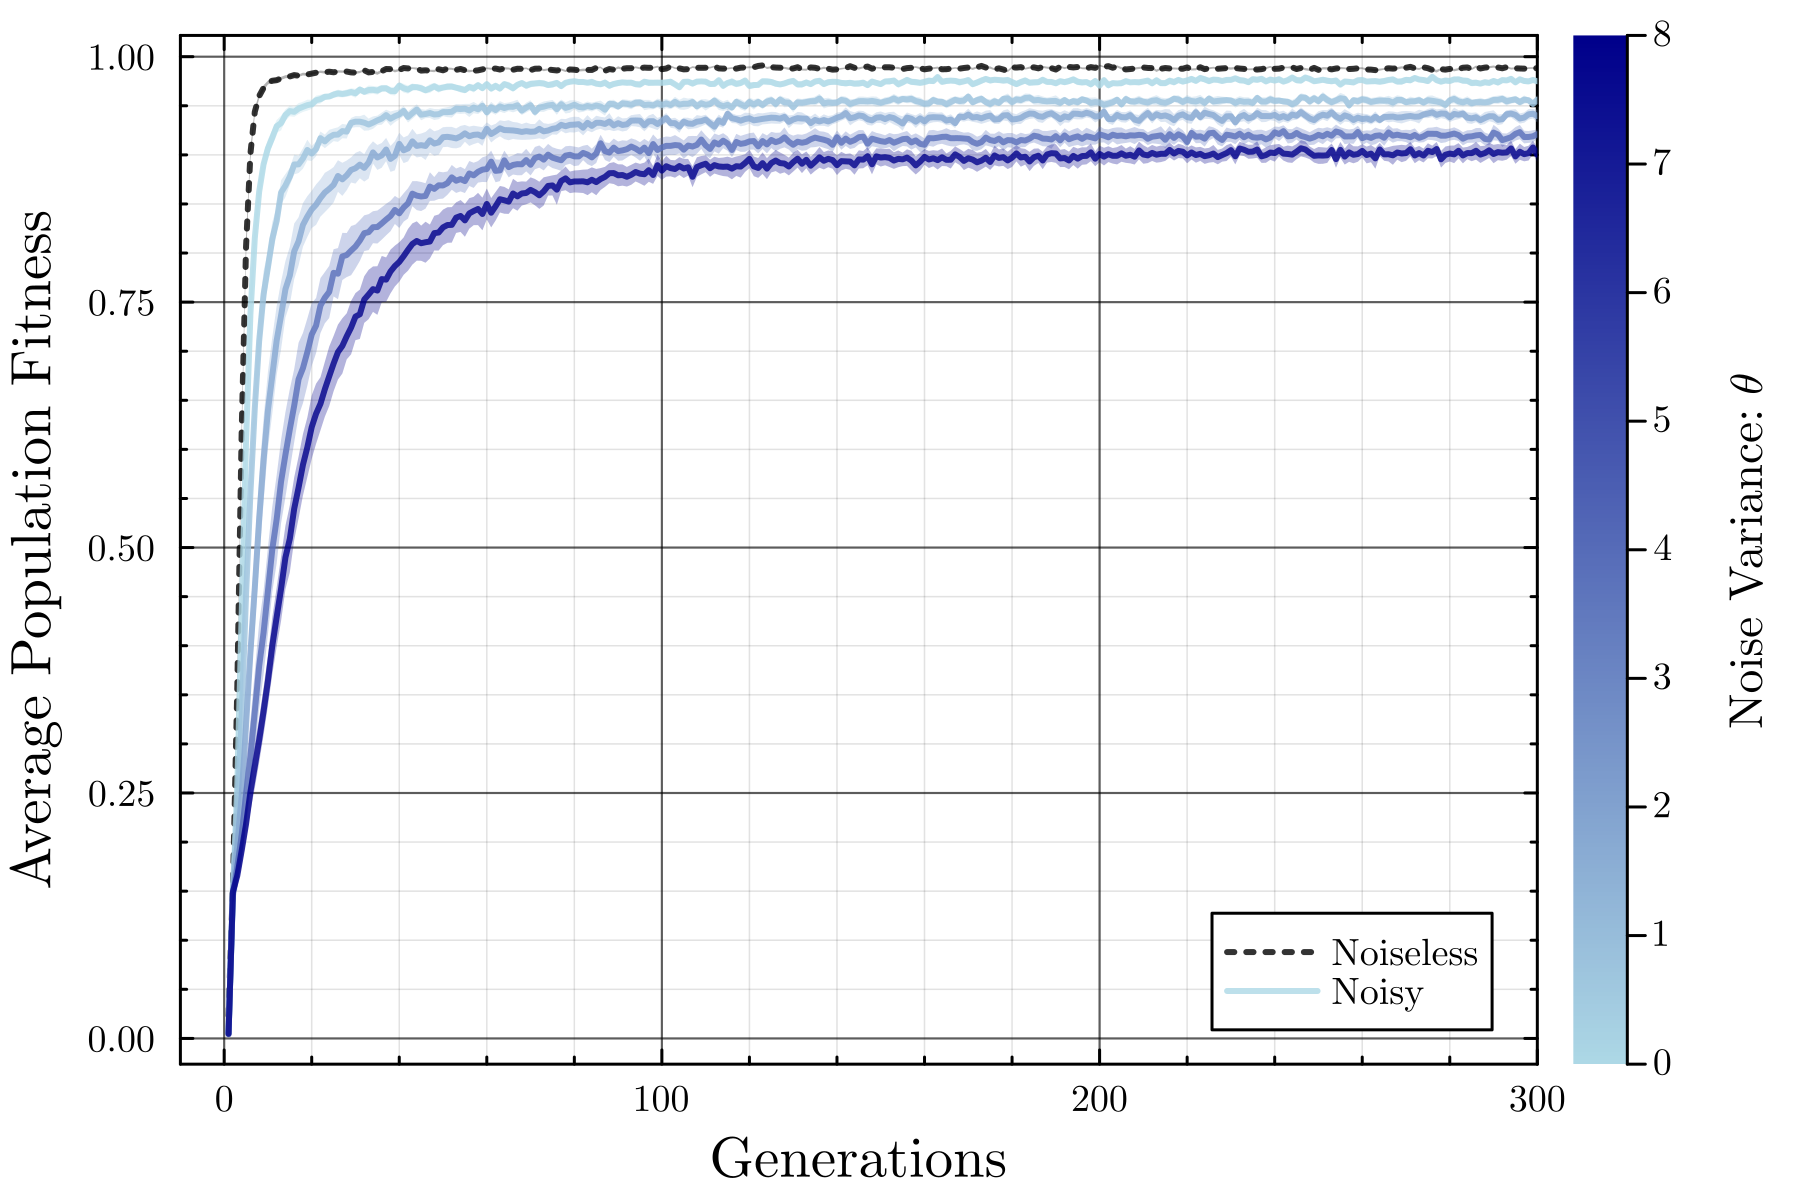

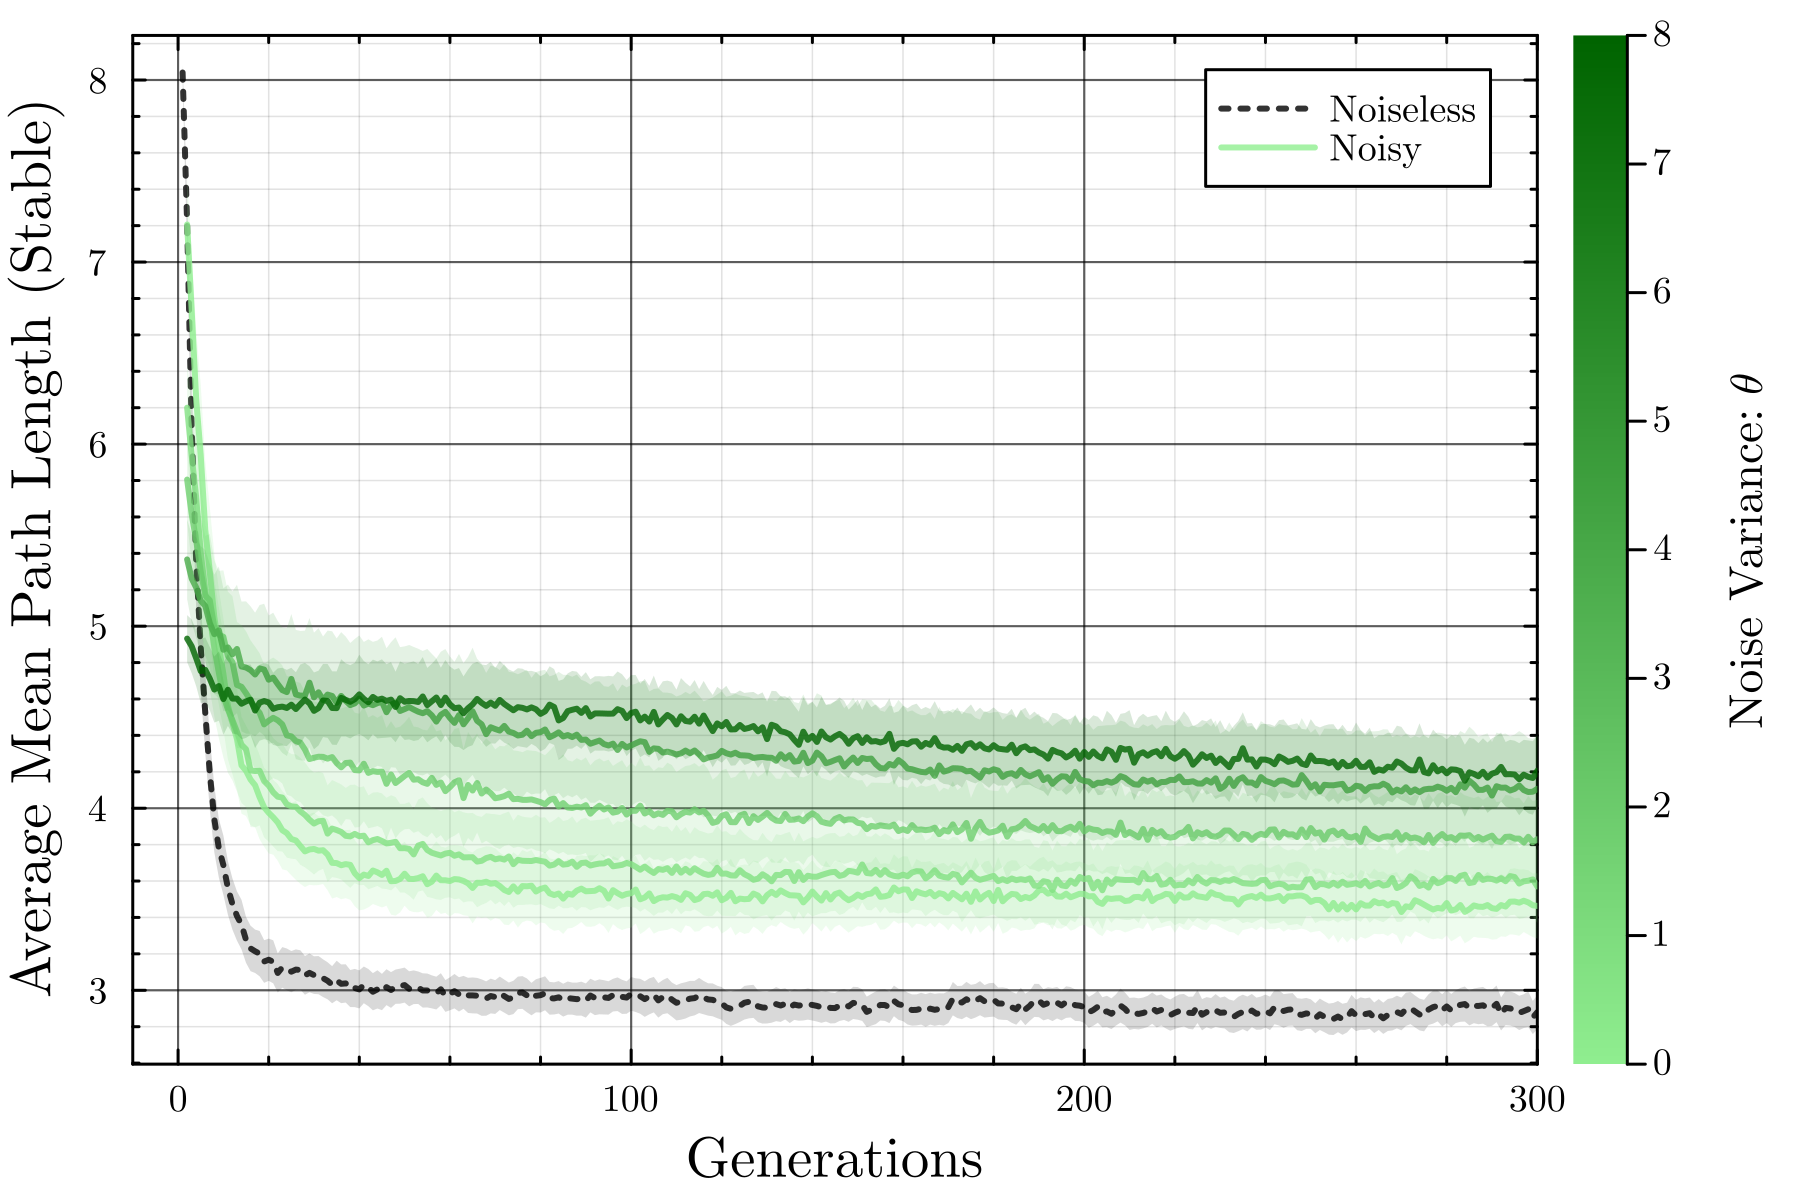

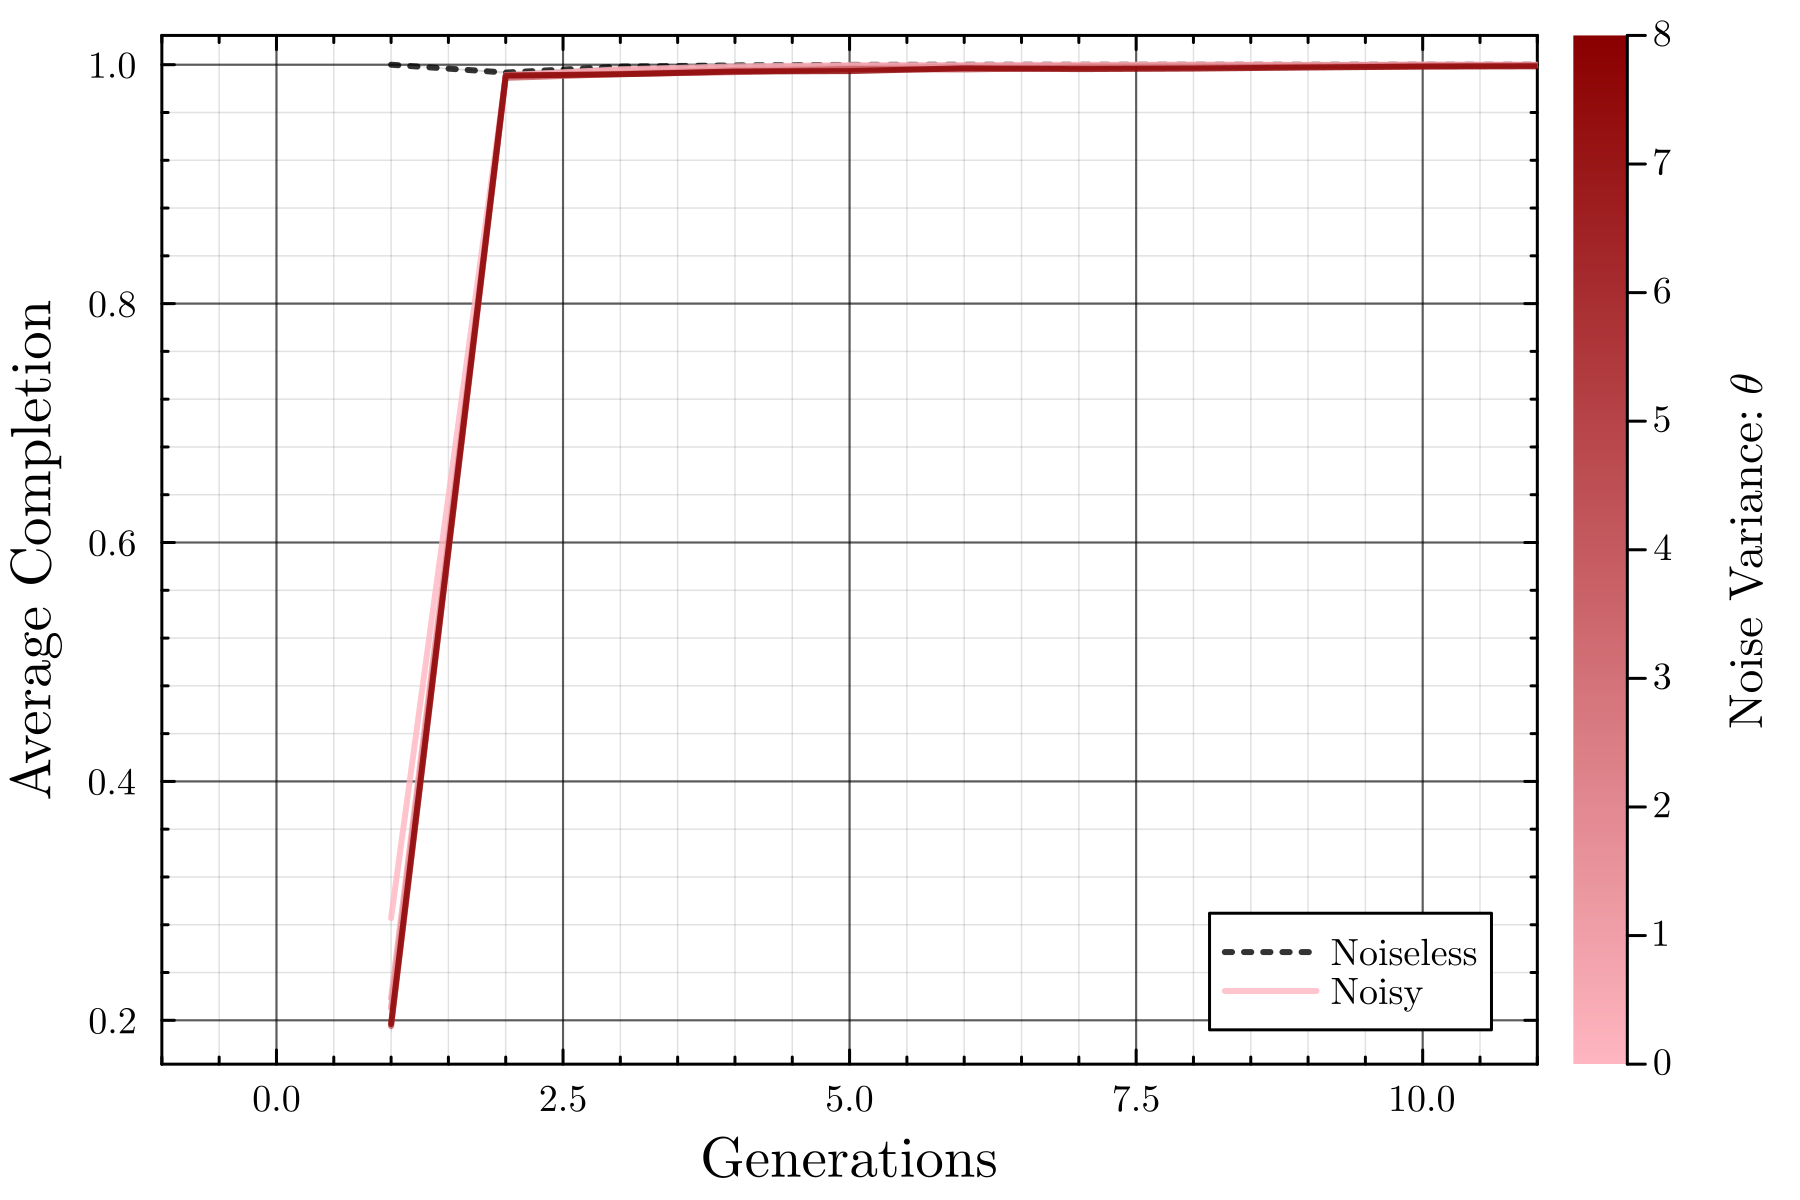

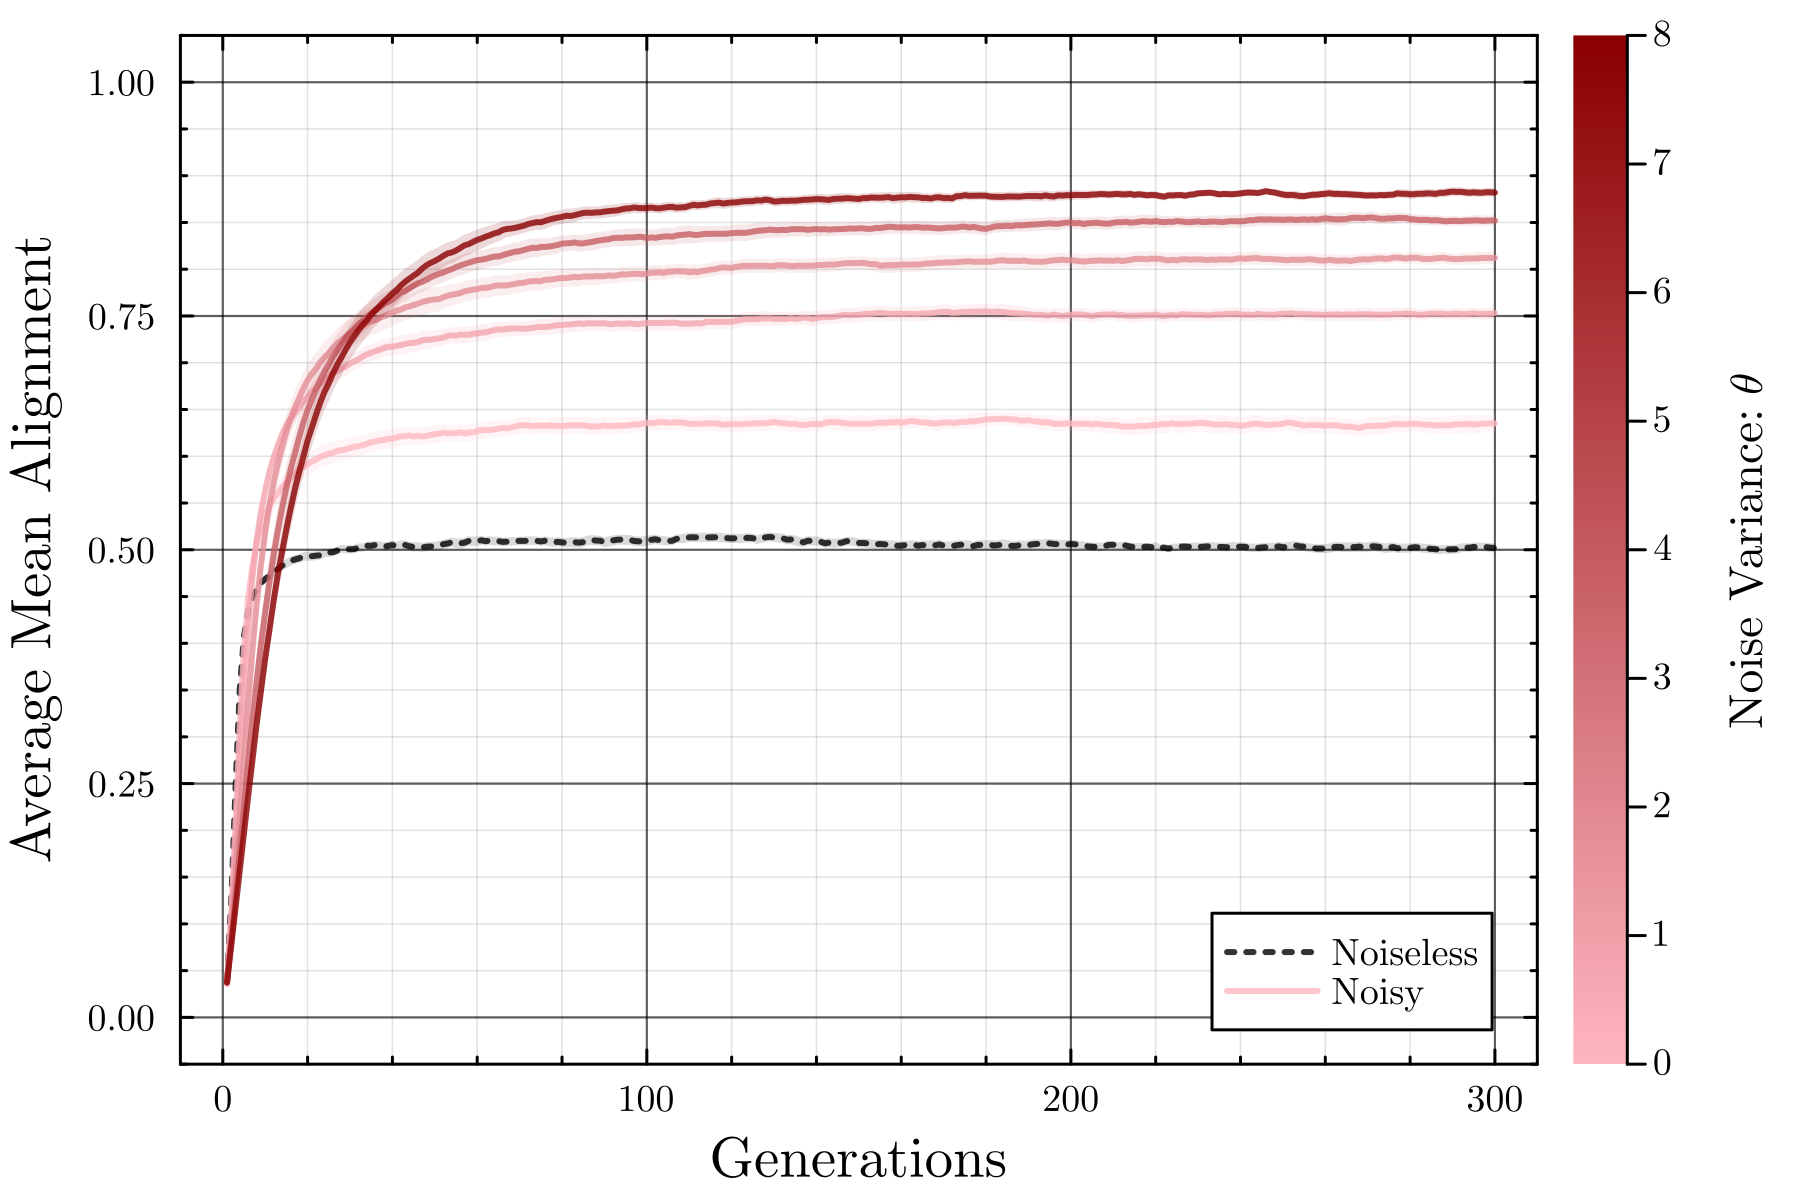

In [5]:
p1 = plot_metric_many_trials(parameters["G"], noise_dists, dists_avgs_fit, dists_sems_fit;
    xlabel="Generations", ylabel="Average Population Fitness", colorscheme=cgrad(:blues),
    size=(1200, 800))
plot!(300, fill(NaN, parameters["G"]),
    zcolor=[0, maximum(thetas)],
    c=:blues,
    label="",
    colorbar=true,
    colorbar_title=L"Noise Variance: $θ$",
    colorbar_titlefontsize=10)
xlims!(-10, 300) 
savefig(p1, "fitness_evolution.png")

p2 = plot_metric_many_trials(300, noise_dists, dists_avgs_path, dists_sems_path; 
    xlabel="Generations", ylabel="Average Mean Path Length (Stable)", colorscheme=cgrad(:greens),
    size=(1200, 800), init_gen=2, fillalpha=0.15)
plot!(200, fill(NaN, 200),
    zcolor=[0, maximum(thetas)],
    c=:greens,
    label="",
    colorbar=true,
    colorbar_title=L"Noise Variance: $θ$",
    colorbar_titlefontsize=10)

xlims!(-10, 300) 

savefig(p2, "path_evolution.png")

p3 = plot_metric_many_trials(15, noise_dists, dists_avgs_compl, dists_sems_compl;
    xlabel="Generations", ylabel="Average Completion", colorscheme=cgrad(:reds),
    size=(1200, 800), init_gen=1, fillalpha=0.15)
plot!(15, fill(NaN, 15),
    zcolor=[0, maximum(thetas)],
    c=:reds,
    label="",
    colorbar=true,
    colorbar_title=L"Noise Variance: $θ$",
    colorbar_titlefontsize=10)
xlims!(-1, 11)

savefig(p3, "completion_evolution.png")

p4 = plot_metric_many_trials(300, noise_dists, dists_avgs_alignment, dists_sems_alignment; 
    xlabel="Generations", ylabel="Average Mean Alignment", colorscheme=cgrad(:reds),
    size=(1200, 800), init_gen=1, fillalpha=0.15)
plot!(15, fill(NaN, 15),
    zcolor=[0, maximum(thetas)],
    c=:reds,
    label="",
    colorbar=true,
    colorbar_title=L"Noise Variance: $θ$",
    colorbar_titlefontsize=10)
ylims!(-0.05, 1.05)

savefig(p4, "alignment_evolution.png")

display(p1)
display(p2)
display(p3)
display(p4)

In [6]:
# Alignment Two Sided test

# --- 2. Prepare Samples ---

noiseless_sample = final_avg_alignments[1, :]
noisy_evo_alignment = final_avg_alignments[2:end,:] 
noisy_sample = vec(noisy_evo_alignment) # flatten 


println("Sample 1 (Noiseless): $(length(noiseless_sample)) data points")
println("Sample 2 (Noisy):     $(length(noisy_sample)) data points")

# Let's check the means as a sanity check
println("Mean (Noiseless): $(mean(noiseless_sample))")
println("Mean (Noisy):     $(mean(noisy_sample))")
println("-"^30)


# --- 3. Run the Statistical Test ---

# H_0 (null hypothesis):     mean(noiseless) == mean(noisy)
# H_a (alt. hypothesis):    mean(noiseless) != mean(noisy)  

# We use UnequalVarianceTTest for Welch's test
test_result = UnequalVarianceTTest(noiseless_sample, noisy_sample)

# --- 4. Get the Two-Sided P-Value ---

# To test your new hypothesis (noiseless != noisy), we need a two-sided
# p-value. This is the default for `pvalue()`.
p_val = pvalue(test_result)

println("Test Result:\n", test_result)
println("\nP-value (for H_a: noiseless != noisy): $(p_val)")


# --- 5. Interpretation ---
alpha = 0.05 # Your significance level
if p_val < alpha
    println("\nConclusion: The p-value ($p_val) is less than alpha ($alpha).")
    println("We REJECT the null hypothesis.")
    println("The data suggests that the noiseless alignment is statistically DIFFERENT from the noisy alignment.") # <-- CHANGED
else
    println("\nConclusion: The p-value ($p_val) is not less than alpha ($alpha).")
    println("We FAIL to reject the null hypothesis.")
    println("There is not enough statistical evidence to conclude a significant DIFFERENCE between the noiseless and noisy alignments.") # <-- CHANGED
end

Sample 1 (Noiseless): 30 data points
Sample 2 (Noisy):     150 data points
Mean (Noiseless): 0.5021329480742166
Mean (Noisy):     0.7882072524320894
------------------------------
Test Result:
Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -0.286074
    95% confidence interval: (-0.3031, -0.269)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-72

Details:
    number of observations:   [30,150]
    t-statistic:              -33.16532589089353
    degrees of freedom:       157.63833283595412
    empirical standard error: 0.008625704607848362


P-value (for H_a: noiseless != noisy): 5.575079864073052e-73

Conclusion: The p-value (5.575079864073052e-73) is less than alpha (0.05).
We REJECT the null hypothesis.
The data suggests that the noiseless alignment is statistically DIFFERENT from the n

Data prepared:
X (Noise Levels): [0.5, 1.0, 1.4142135623730951, 2.0, 2.8284271247461903]
Y (Avg Alignment): [0.638, 0.753, 0.814, 0.853, 0.883]
Y Err (SEM):       [0.004, 0.003, 0.003, 0.002, 0.002]
----------------------------------------
Linear Regression Results:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  0.634449    0.0413554  15.34    0.0006  0.502838    0.766061
Noise        0.0992929   0.02368     4.19    0.0247  0.0239325   0.174653
─────────────────────────────────────────────────────────────────────────
----------------------------------------
Intercept: 0.6344
Slope (Noise): 0.0993
R²: 0.8542426118370621


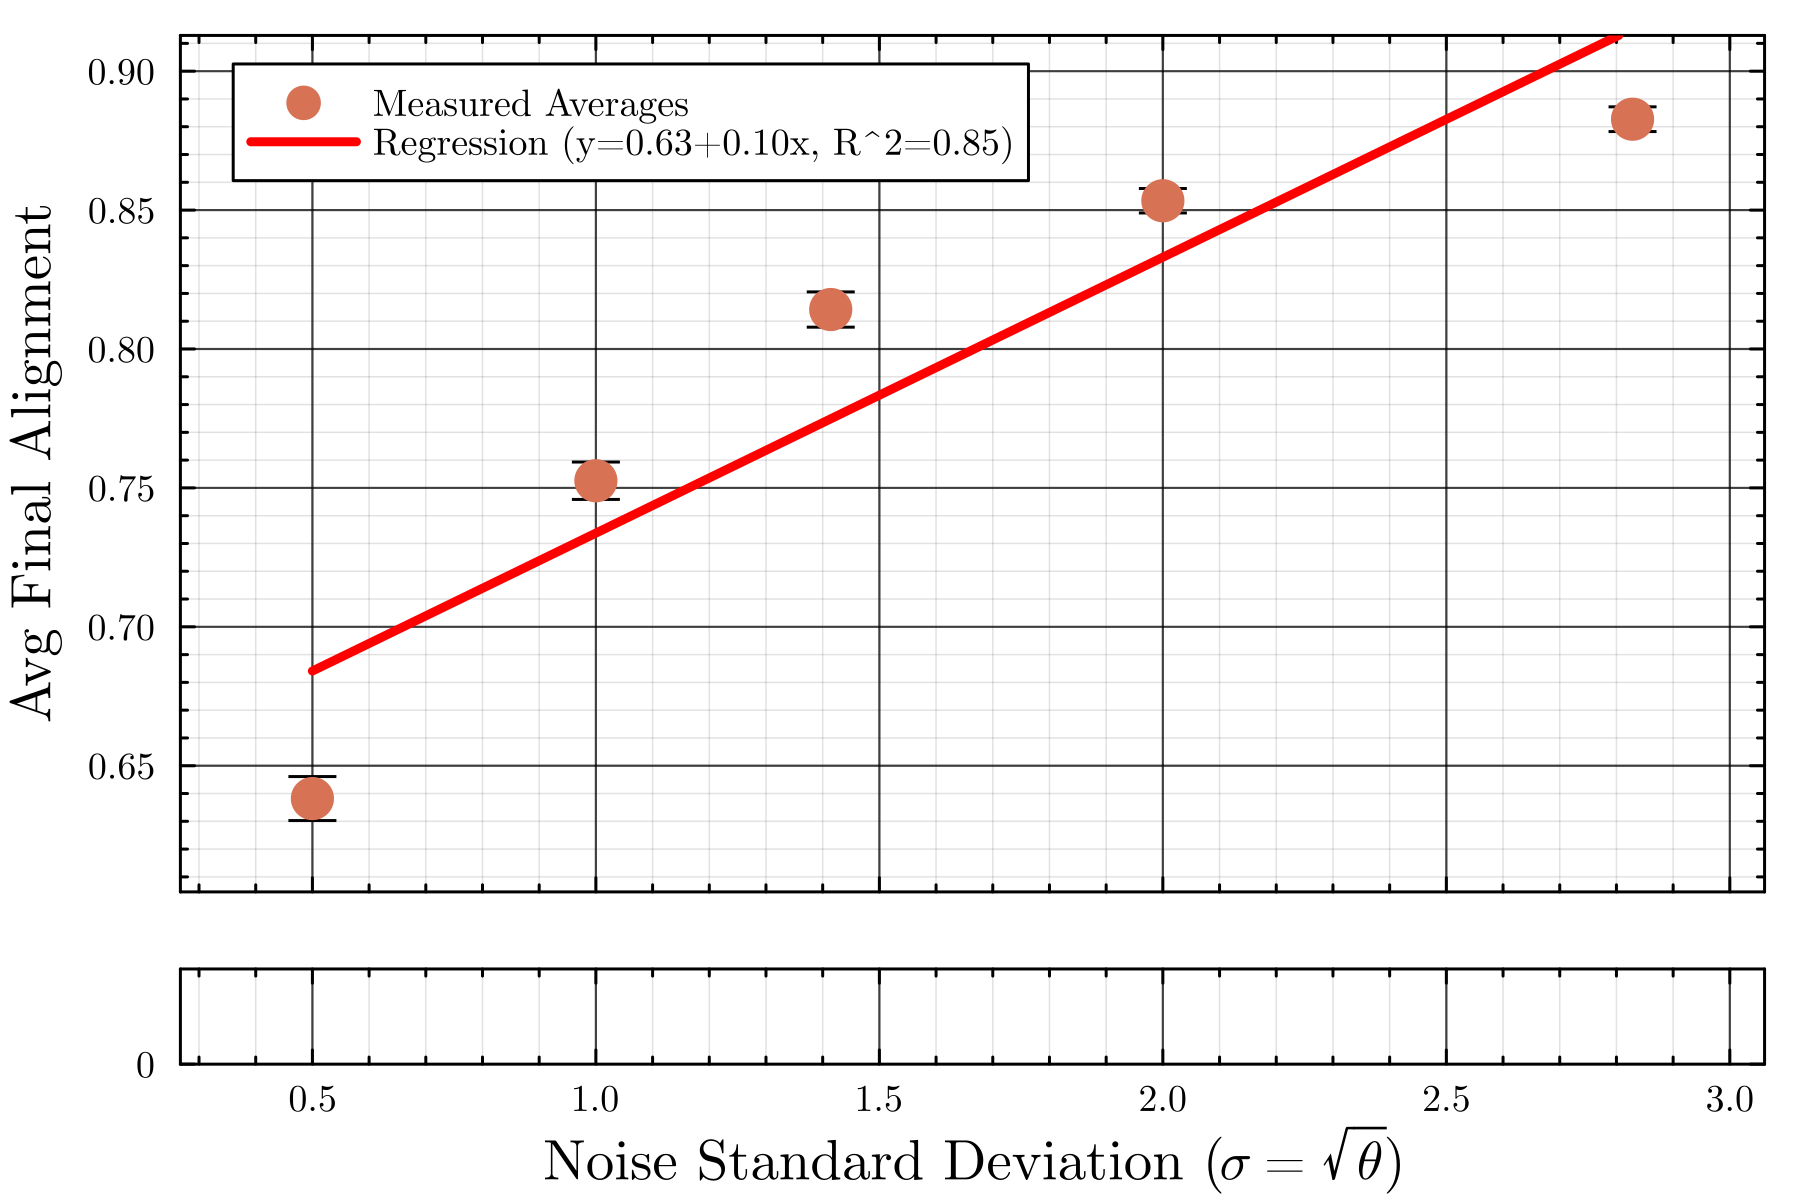

In [7]:
using Plots
using GLM
using DataFrames
using Statistics
using Printf # For nice printing
using LaTeXStrings # For L"..." string macro

# === 2. DATA PREPARATION ===
noisy_alignment_avgs = vec(mean(noisy_evo_alignment, dims=2))
noisy_alignment_sems = vec(std(noisy_evo_alignment, dims=2) / sqrt(trials))
x_vals = sqrt.(thetas) # x_vals = sqrt.(thetas)

println("Data prepared:")
println("X (Noise Levels): ", x_vals)
println("Y (Avg Alignment): ", round.(noisy_alignment_avgs, digits=3))
println("Y Err (SEM):       ", round.(noisy_alignment_sems, digits=3))
println("-"^40)


# === 3. LINEAR REGRESSION ===
df = DataFrame(Noise=x_vals, Alignment=noisy_alignment_avgs)
model = lm(@formula(Alignment ~ Noise), df)
results = coeftable(model)

println("Linear Regression Results:")
println(results)
println("-"^40)

intercept = coef(model)[1]
slope = coef(model)[2]
@printf("Intercept: %.4f\n", intercept)
@printf("Slope (Noise): %.4f\n", slope)
println("R²: ", r2(model))

y_pred = predict(model)

# === 4. SETUP PLOT LIMITS FOR BROKEN AXIS ===

# Calculate the min/max of your *actual data* (averages + error bars)
ci_95 = noisy_alignment_sems * 1.96
data_min = minimum(noisy_alignment_avgs .- ci_95)
data_max = maximum(noisy_alignment_avgs .+ ci_95)
data_range = data_max - data_min
padding = data_range * 0.1 # Add 10% padding

# Limits for the top plot
top_ylims = (data_min - padding, data_max + padding)

# Limits for the bottom "stub" plot (just shows 0)
bottom_ylims = (0, 0.01) # A tiny range just to show 0

# Ensure x-axes are identical
data_xmin = minimum(x_vals)
data_xmax = maximum(x_vals)
x_range = data_xmax - data_xmin
x_padding = x_range * 0.1
shared_xlims = (data_xmin - x_padding, data_xmax + x_padding)


# === 5. CREATE THE TWO PLOTS ===

# 5a. Create the TOP plot (main data)
p_top = scatter(
    x_vals,
    noisy_alignment_avgs,
    yerror=ci_95, # 95% CI
    linecolor=:black, linewidth=1,
    label="Measured Averages",
    ylabel="Avg Final Alignment",
    legend=:best,
    markersize=8,
    ylims=top_ylims,     # <-- Set Y limits for top
    xlims=shared_xlims,  # <-- Set shared X limits
    xformatter=_ -> "", # <-- Fix 1: Keep grid, hide x-labels
    bottom_margin=1Plots.px, # <-- Fix 2: Reduce gap
    grid=:all,
    gridalpha=0.5
)

# Add the regression line to the TOP plot
plot!(
    p_top,
    x_vals,
    y_pred,
    label=@sprintf("Regression (y=%.2f+%.2fx, R^2=%.2f)", intercept, slope, r2(model)),
    linewidth=3,
    color=:red
)

# 5b. Create the BOTTOM plot (zero stub)
p_bottom = plot(
    x_vals, # Plot *something* to set x-axis
    fill(bottom_ylims[1], length(x_vals)), # Plot invisible points at 0
    alpha=0, # Make them invisible
    xlabel=L"Noise Standard Deviation ($\sigma = \sqrt{\theta}$)", # X-label here
    legend=false,
    ylims=bottom_ylims,    # <-- Set Y limits for bottom
    yticks=[0],            # <-- Only show tick at 0
    ylabel="",             # <-- No y-label
    xlims=shared_xlims,    # <-- Set shared X limits
    top_margin=1Plots.px, # <-- Fix 2: Reduce gap
    grid=:all,            # <-- Explicitly add grid
    gridalpha=0.5
)


# === 6. COMBINE PLOTS ===
final_plot = plot(
    p_top,
    p_bottom,
    layout=@layout([a{0.9h}; b{0.1h}]), # 80% height for top, 20% for bottom
    dpi=300
)

# === 7. SAVE AND DISPLAY ===
savefig(final_plot, "alignment_regression_broken_axis.png")
display(final_plot);

# Experiment 2 - Coherence and concentration of loops

In [8]:
"""
    create_scatterplot(data_dict)

Generates and displays a scatterplot from a dictionary of type counts.
Points are colored blue if their type key contains "Coherent" and red if
it contains "Incoherent".

# Arguments
- `data_dict::Dict`: A dictionary where keys are category names (String)
  and values are arrays of numbers.
"""
function create_scatterplot(data_dict::Dict)
    if isempty(data_dict)
        println("The data dictionary is empty. Cannot generate a plot.")
        return
    end

    # Initialize empty arrays to hold the flattened data for plotting
    x_data = String[]
    y_data = Number[]
    colors = Symbol[] # Array to hold the color for each point

    # Loop through the dictionary to flatten it for the scatterplot
    # We sort the keys to ensure the plot has a consistent order
    sorted_keys = sort(collect(keys(data_dict)))

    for key in sorted_keys
        values = data_dict[key]
        
        # Determine the color based on the key name
        local color
        if occursin("incoherent", lowercase(key))
            color = :red
        else
            color = :blue
        end

        # For each value in the array, add the key, value, and color
        append!(x_data, fill(key, length(values)))
        append!(y_data, values)
        append!(colors, fill(color, length(values)))
    end

    # --- Plotting ---
    # Create the scatterplot. The `markercolor` argument applies the color to each point.
    p = scatter(
        x_data, 
        y_data, 
        title="Distribution of FFL Type Counts",
        xlabel="FFL Type",
        ylabel="Percentage of Loops",
        legend=false, # Not needed for this plot
        xrotation=45,
        grid=:y,
        gridstyle=:dash,
        gridalpha=0.7,
        markercolor=colors, # Apply the individual point colors
        markeralpha=0.7,
        markersize=5,
        figsize=(800, 500), 
        alpha = 0.1
    )

    # Display the plot in the default plot pane or a new window
    return p
end;

In [9]:
"""
    create_summary_plots(data_dict, null_expectation)

Creates two comparison plots between empirical data and a null model:
1. Left: average ± standard error
2. Right: 50% and 95% percentile ranges

# Arguments
- `data_dict::Dict{String, Vector{<:Number}}`: observed data
- `null_expectation::Dict{String, Tuple{<:Number, <:Number}}`: expected mean and SE from null model
"""
function create_summary_plots(data_dict::Dict, null_expectation::Dict)
    if isempty(data_dict)
        println("The data dictionary is empty. Cannot generate a plot.")
        return
    end

    sorted_keys = sort(collect(keys(data_dict)))
    means = [mean(data_dict[k]) for k in sorted_keys]
    ses = [std(data_dict[k]) / sqrt(length(data_dict[k])) for k in sorted_keys]
    p50_lower = [quantile(data_dict[k], 0.25) for k in sorted_keys]
    p50_upper = [quantile(data_dict[k], 0.75) for k in sorted_keys]
    p95_lower = [quantile(data_dict[k], 0.025) for k in sorted_keys]
    p95_upper = [quantile(data_dict[k], 0.975) for k in sorted_keys]

    maximum_val = maximum(p95_upper) + 0.1

    null_means = [null_expectation[k][1] for k in sorted_keys]
    null_ses = [null_expectation[k][2] for k in sorted_keys]

    colors = [occursin("incoherent", lowercase(k)) ? :red : :blue for k in sorted_keys]

    # --- Left: mean ± SE ---
    p1 = plot(
        sorted_keys, means,
        yerror=ses .* 1.96,
        seriestype=:scatter,
        markershape=:circle,
        color=colors,
        markerstrokewidth=1.0,
        markersize=8,
        alpha=0.9,
        label="Data",
        xlabel="FFL Type",
        ylabel="Average (%)",
        title="Average ± 2 SE vs Null Model",
        xrotation=45,
        legend=:topleft,
        grid=:y,
        gridstyle=:dash,
        linewidth=2,
        margin=5mm
    )

    plot!(p1, sorted_keys, null_means,
        yerror=null_ses .* 1.96,
        seriestype=:scatter,
        markershape=:x,
        markercolor=:black,
        markerstrokewidth=1,   # <<–– makes the X thicker
        markersize=9,
        linewidth=1,
        alpha=0.9,
        label="Null Model")

    # --- Right: percentile ranges ---
    p2 = plot(
        xlabel="FFL Type", ylabel="Value",
        title="Percentile Ranges vs Null Model",
        xrotation=45, legend=:topleft,
        ylim=(0, maximum_val)
    )

    for (i, k) in enumerate(sorted_keys)
        # Labels only once
        label95 = (i == 1) ? "95% Percentile" : ""
        label50 = (i == 1) ? "50% Percentile" : ""
        labelNull = (i == 1) ? "Null ± 2 SE" : ""

        # 95% range (light gray band)
        plot!(p2, [k, k], [p95_lower[i], p95_upper[i]],
            color=:gray, lw=6, alpha=0.5, label=label95)

        # 50% range (colored thicker band)
        plot!(p2, [k, k], [p50_lower[i], p50_upper[i]],
            color=colors[i], lw=8, alpha=0.8, label=label50)

        # Null model mean ± SE
        plot!(p2, [k, k],
            [null_means[i] - null_ses[i] * 1.96, null_means[i] + null_ses[i] * 1.96],
            color=:black, lw=2, alpha=0.9, label=labelNull)

        scatter!(p2, [k], [null_means[i]],
            color=:black, marker=:x, markersize=8, label="")
    end

    combined = plot(p1, p2, layout=(1, 2), size=(1100, 500))
    return combined
end


create_summary_plots

In [10]:
"""Some Helper Functions"""


"""
    compute_ffl_type_counts(matrices::Vector{<:AbstractMatrix}, phen_opt)

Given a vector of matrices, returns a dictionary `Dict{String, Vector{Float64}}`
containing the normalized counts of FFL types for each matrix.

Each key corresponds to a motif type, and each value is a vector with one element
per input matrix. Missing motif types are filled with 0s.
"""
function compute_ffl_type_counts(matrices::Vector{Matrix{Float64}}, phen_opt)
    if isempty(matrices)
        println("No matrices provided.")
        return Dict{String,Vector{Float64}}()
    end

    # Prepare the result container
    all_types_counts = Dict{String,Vector{Float64}}()
    n = length(matrices)
    sizes = zeros(Float64, n)

    # --- 1. Identify all possible keys (FFL types) first ---
    # Run once to get all possible keys from the Python function
    mat0 = copy(matrices[1])
    mat0[diagind(mat0)] .= 0
    _, type_counts_example = py"count_ffl_types"(mat0, visualize=false, phen_opt=phen_opt)
    all_keys = collect(keys(type_counts_example))

    # Initialize dictionary with zeros
    for k in all_keys
        all_types_counts[k] = zeros(n)
    end

    # --- 2. Process each matrix ---
    for (index, W) in enumerate(matrices)
        W_noloop = copy(W)
        W_noloop[diagind(W_noloop)] .= 0

        # Get motif counts from Python
        _, type_counts = py"count_ffl_types"(W_noloop, visualize=false, phen_opt=phen_opt)

        # Normalize counts
        norm = sum(values(type_counts))
        sizes[index] = norm > 0 ? norm : 1.0  # Avoid div by zero

        # Fill in zeros for missing keys
        for k in all_keys
            value = haskey(type_counts, k) ? type_counts[k] : 0.0
            all_types_counts[k][index] = value / sizes[index]
        end
    end

    return all_types_counts
end

function compute_fbck_type_counts(matrices::Vector{Matrix{Float64}}; max_size::Int=4)
    if isempty(matrices)
        println("No matrices provided.")
        return Dict{Int,Matrix{Float64}}()
    end

    n = length(matrices)
    all_types_counts = Dict{Int,Matrix{Float64}}()

    # Initialize dictionary: each entry will store an n×2 matrix
    # column 1 = proportion of Positive loops, column 2 = Negative
    for k in 1:max_size
        all_types_counts[k] = zeros(n, 2)
    end

    for (i, W) in enumerate(matrices)
        # Call Python function
        _, type_counts = py"count_feedback_loops"(W, max_size=max_size)

        for size in 1:max_size
            if haskey(type_counts, size)
                # Safe dictionary access
                type_dict = type_counts[size]
                pos = haskey(type_dict, "Reinforcing Feedback") ? type_dict["Reinforcing Feedback"] : 0
                neg = haskey(type_dict, "Balancing Feedback") ? type_dict["Balancing Feedback"] : 0
                total = pos + neg

                if total > 0
                    all_types_counts[size][i, :] .= [pos / total, neg / total]
                end
            end
        end
    end

    return all_types_counts
end

"""
    get_expectations(data::Dict{String, Vector{Float64}})

Calculates the mean and the standard error of the mean for each data series in a dictionary.

# Arguments
- `data::Dict{String, Vector{Float64}}`: A dictionary where each key is a `String` identifier (e.g., a sample name) and 
    the corresponding value is a `Vector{Float64}` of numerical observations.

# Returns
- `Dict{String, Vector{Float64}}`: A new dictionary with the same keys as the input `data`. Each value is a two-element 
    `Vector{Float64}` containing:
    1. The sample mean (`μ`).
    2. The standard error of the mean (`σ / √n`).
"""

function get_expectations(data::Dict)
    expectation = Dict{Any,Vector{Float64}}()
    for (key, values) in data
        μ = mean(values)
        σ = std(values)
        n = length(values)
        expectation[key] = [μ, σ / sqrt(n)]
    end
    return expectation
end

get_expectations (generic function with 1 method)

In [11]:
# Computing the distribution given random matrices

parameters = BooleanNetwork.STANDARD_PARAMETERS
parameters["G"] = 500 # 
parameters["pop_size"] = 300 
parameters["mode"] = "stable" 

trials = 30
max_size_fbcks = 5

averages_random_ffls = Dict{String,Vector{Float64}}()
averages_random_fbcks_reinf = Dict{Int,Vector{Float64}}()
averages_random_fbcks_balanc = Dict{Int,Vector{Float64}}()

for n in 1:max_size_fbcks
    averages_random_fbcks_reinf[n] = zeros(trials)
    averages_random_fbcks_balanc[n] = zeros(trials)
end

progress = Progress(trials; desc="Running experiments for random matrices...", barlen=5)
counter = Atomic{Int}(0)


for trial in 1:trials
    phen_opt = sample([1, -1], Weights([parameters["p_phen"], 1 - parameters["p_phen"]]), parameters["N_target"]) # Example optimum
    # Ws = [randn(parameters["N_target"], parameters["N_target"]) for i in 1:parameters["pop_size"]]

    Ws = BooleanNetwork.initialize_population(parameters, BooleanNetwork.make_initial_state,BooleanNetwork.make_optimal_phenotype,BooleanNetwork.activation)[3]
    Ws = [Matrix(W) for W in Ws]

    types_counts_random = compute_ffl_type_counts(Ws, phen_opt)

    # Compute mean per type for this trial - FFLs
    trial_means = Dict{String,Float64}()
    for (key, values) in types_counts_random
        trial_means[key] = mean(values)
    end

    for (key, val) in trial_means
        if !haskey(averages_random_ffls, key)
            averages_random_ffls[key] = zeros(trials)
        end
        averages_random_ffls[key][trial] = val
    end

    # Compute mean per type for this trial - FBCKs

    fbck_props_per_size = compute_fbck_type_counts(Ws, max_size=max_size_fbcks)

    # Get the average concentration per size of feedback loops

    for n in 1:max_size_fbcks
        avg_reinforcing = mean(fbck_props_per_size[n][:,1])
        avg_balancing = mean(fbck_props_per_size[n][:,2])
        averages_random_fbcks_reinf[n][trial] = avg_reinforcing
        averages_random_fbcks_balanc[n][trial] = avg_balancing
    end

    atomic_add!(counter, 1)
    next!(progress)
end

expectation_random = get_expectations(averages_random_ffls)
expectations_random_fbcks_reinf = get_expectations(averages_random_fbcks_reinf)
expectations_random_fbcks_balanc = get_expectations(averages_random_fbcks_balanc)

Running experiments for random matrices... 100%|█████| Time: 1:12:51


Dict{Any, Vector{Float64}} with 5 entries:
  5 => [0.499729, 5.46968e-5]
  4 => [0.498856, 0.00014398]
  2 => [0.476943, 0.000826519]
  3 => [0.493664, 0.000320983]
  1 => [0.384222, 0.00140109]

In [12]:
# Noiseless Evolution

parameters["noise_dist"] = Bernoulli(1.0); # Always 1

averages_noiseless = Dict{String,Vector{Float64}}()

progress = Progress(trials; desc="Running experiments for noiseless...", barlen=5)
counter = Atomic{Int}(0)

averages_noiseless_fbcks_reinf = Dict{Int,Vector{Float64}}()
averages_noiseless_fbcks_balanc = Dict{Int,Vector{Float64}}()

for n in 1:max_size_fbcks
    averages_noiseless_fbcks_reinf[n] = zeros(trials)
    averages_noiseless_fbcks_balanc[n] = zeros(trials)
end

for trial in 1:trials
    run_data = BooleanNetwork.run_simulation(parameters)
    evolved_matrices = run_data["matrices"][end, 1:30] # Restrict to sample 30 matrices 
    type_counts = compute_ffl_type_counts(evolved_matrices, run_data["phenotypic_optima"])

    # Compute mean per type for this trial
    trial_means = Dict{String,Float64}()
    for (key, values) in type_counts
        trial_means[key] = mean(values)
    end

    for (key, val) in trial_means
        if !haskey(averages_noiseless, key)
            averages_noiseless[key] = zeros(trials)
        end
        averages_noiseless[key][trial] = val
    end

    # Compute mean per type for this trial - FBCKs

    fbck_props_per_size = compute_fbck_type_counts(evolved_matrices, max_size=max_size_fbcks)

    # Get the average concentration per size of feedback loops

    for n in 1:max_size_fbcks
        avg_reinforcing = mean(fbck_props_per_size[n][:,1])
        avg_balancing = mean(fbck_props_per_size[n][:,2])
        averages_noiseless_fbcks_reinf[n][trial] = avg_reinforcing
        averages_noiseless_fbcks_balanc[n][trial] = avg_balancing
    end

    atomic_add!(counter, 1)
    next!(progress)
end

expectation_noiseless = get_expectations(averages_noiseless)
expectations_noiseless_fbcks_reinf = get_expectations(averages_random_fbcks_reinf)
expectations_noiseless_fbcks_balanc = get_expectations(averages_random_fbcks_balanc);

Running experiments for noiseless... 100%|█████| Time: 0:08:38


In [13]:
# Very Noisy Evolution

parameters["noise_dist"] = Gamma(1/8, 8)
averages_noisy = Dict{String,Vector{Float64}}()


progress = Progress(trials; desc="Running experiments for very noisy...", barlen=5)
counter = Atomic{Int}(0)

averages_noisy_fbcks_reinf = Dict{Int,Vector{Float64}}()
averages_noisy_fbcks_balanc = Dict{Int,Vector{Float64}}()

for n in 1:max_size_fbcks
    averages_noisy_fbcks_reinf[n] = zeros(trials)
    averages_noisy_fbcks_balanc[n] = zeros(trials)
end

for trial in 1:trials
    run_data = BooleanNetwork.run_simulation(parameters)
    evolved_matrices = run_data["matrices"][end, 1:30] # Restrict to sample 30 matrices per simulation :(
    type_counts = compute_ffl_type_counts(evolved_matrices, run_data["phenotypic_optima"])

    # Compute mean per type for this trial
    trial_means = Dict{String,Float64}()
    for (key, values) in type_counts
        trial_means[key] = mean(values)
    end

    for (key, val) in trial_means
        if !haskey(averages_noisy, key)
            averages_noisy[key] = zeros(trials)
        end
        averages_noisy[key][trial] = val
    end

    # Compute mean per type for this trial - FBCKs

    fbck_props_per_size = compute_fbck_type_counts(evolved_matrices, max_size=max_size_fbcks)

    # Get the average concentration per size of feedback loops

    for n in 1:max_size_fbcks
        avg_reinforcing = mean(fbck_props_per_size[n][:, 1])
        avg_balancing = mean(fbck_props_per_size[n][:, 2])
        averages_noisy_fbcks_reinf[n][trial] = avg_reinforcing
        averages_noisy_fbcks_balanc[n][trial] = avg_balancing
    end

    atomic_add!(counter, 1)
    next!(progress)
end

expectation_noisy = get_expectations(averages_noisy)
expectations_noisy_fbcks_reinf = get_expectations(averages_random_fbcks_reinf)
expectations_noisy_fbcks_balanc = get_expectations(averages_random_fbcks_balanc);

Running experiments for very noisy... 100%|█████| Time: 0:17:14


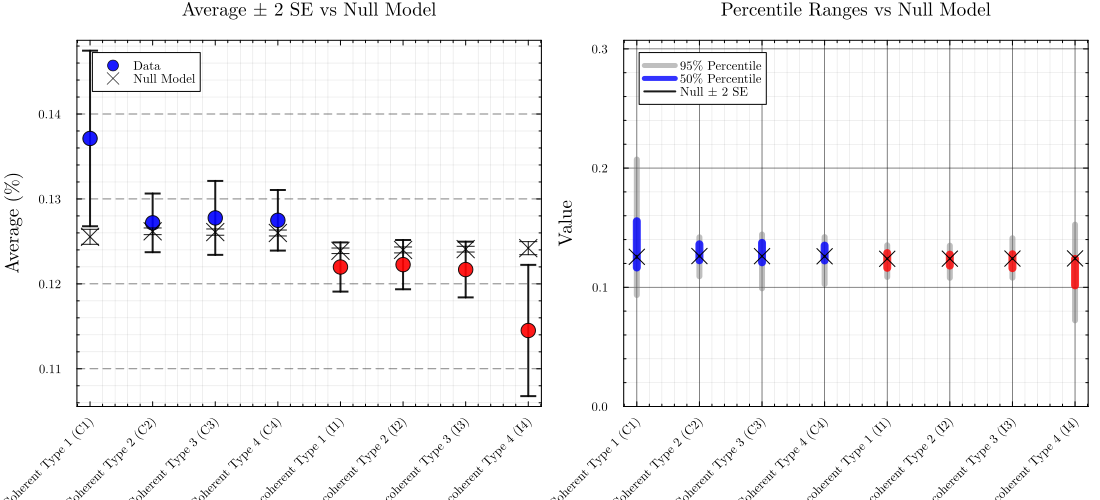

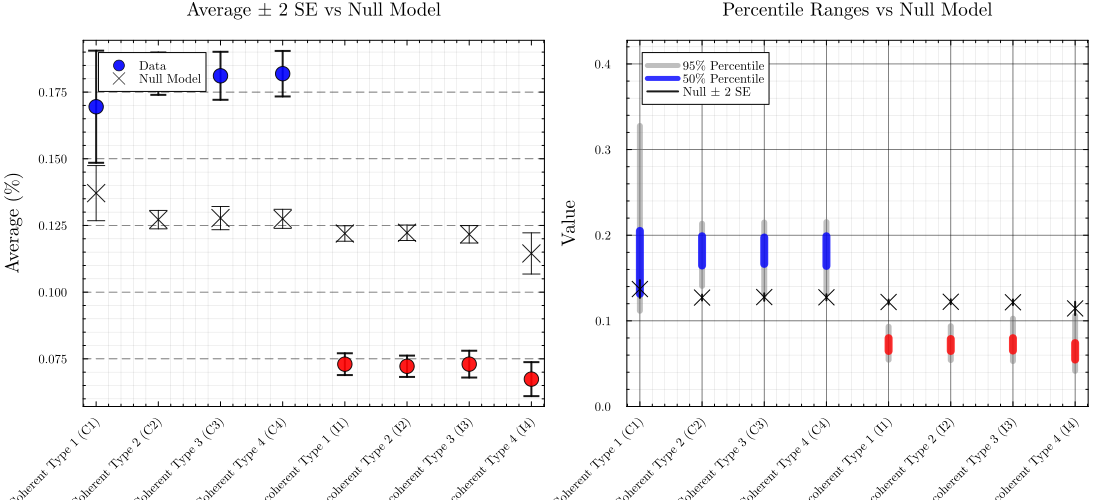

"c:\\Users\\Kichi\\Documents\\Documentos_and_Stuff\\Academic Projects\\SFI GRNs\\NonBooleanNetwork\\evo-algs\\WagnerBoolean\\FilesManuscriptDraft\\High Noise vs Noiseless.png"

In [14]:
# The data to plot are then
# treatment vs null

# noiseless vs random | averages_noiseless, expectation_random
# noisy vs noiseless | expectation_random, averages_noisy

p1 = create_summary_plots(averages_noiseless, expectation_random)
display(p1)
savefig(p1, "Noiseless vs Random Matrices.png")
p2 = create_summary_plots(averages_noisy, expectation_noiseless)
display(p2)
savefig(p2, "High Noise vs Noiseless.png")


In [15]:
using Plots, Statistics

"""
    create_summary_plots(expectations_noiseless::Dict{Int, Tuple{Float64, Float64}},
                         expectations_random::Dict{Int, Tuple{Float64, Float64}},
                         loop_type::String;
                         max_size::Int=4,
                         savepath::Union{Nothing, String}=nothing)

Create a summary plot comparing the mean ± 95% confidence intervals (1.96 × SEM)
of feedback loop concentrations between a noiseless and random ensemble.

# Arguments
- `expectations_noiseless`: Dict mapping loop size → (mean, sem) for noiseless networks.
- `expectations_random`: Dict mapping loop size → (mean, sem) for random networks.
- `loop_type`: "Reinforcing" or "Balancing"
- `max_size`: Maximum loop size to plot.
- `savepath`: Optional path to save the plot (e.g., "figures/feedback_summary.png").
"""
function create_summary_plots_fbcks(expectations_noiseless::Dict{Any,Vector{Float64}},
    expectations_random::Dict{Any,Vector{Float64}},
    loop_type::String;
    max_size::Int=4,
    savepath::Union{Nothing,String}=nothing, color =:blue, dpi = 300)

    sizes = 1:max_size

    # Extract means and SEMs for both cases
    means_noiseless = [expectations_noiseless[s][1] for s in sizes]
    sems_noiseless = [expectations_noiseless[s][2] for s in sizes]

    means_random = [expectations_random[s][1] for s in sizes]
    sems_random = [expectations_random[s][2] for s in sizes]

    # Compute 95% confidence intervals
    ci_factor = 10 # 1.96
    yerr_noiseless = sems_noiseless .* ci_factor
    yerr_random = sems_random .* ci_factor


    # --- Plot Configuration ---
    default(fontfamily="Computer Modern", linewidth=2, framestyle=:box, legendfontsize=10, grid = false)

    plt = plot(
        sizes, means_random,
        yerror=yerr_random,
        seriestype=:scatter,
        label="Null comparison",
        color=:gray,
        marker=:x,
        markercolor=:black,
        markerstrokewidth = 1.0,
        line_color =:gray,
        markersize=9,
        linewidth = 1,
        alpha = 0.9,
        title="$loop_type",
        xlabel="Loop Size",
        ylabel="Proportion",
        legend=:topright,
        grid=false,
        xlims=(0.5, max_size + 0.5),
        ylim=(0, 1), dpi = dpi
    )

    scatter!(plt,
        sizes, means_noiseless,
        yerror=yerr_noiseless,
        label="Evolved Comparisons",
        color=color,
        marker=:circle,
        markersize=8,
        alpha = 0.9,
        xlabel = "Loop Size",
        ylabel = "Average Concentration",
        legend =:best,
        linewidth = 1.5,
        grid = false
    )

    if !isnothing(savepath)
        savefig(plt, savepath)
    end

    return plt
end

create_summary_plots_fbcks

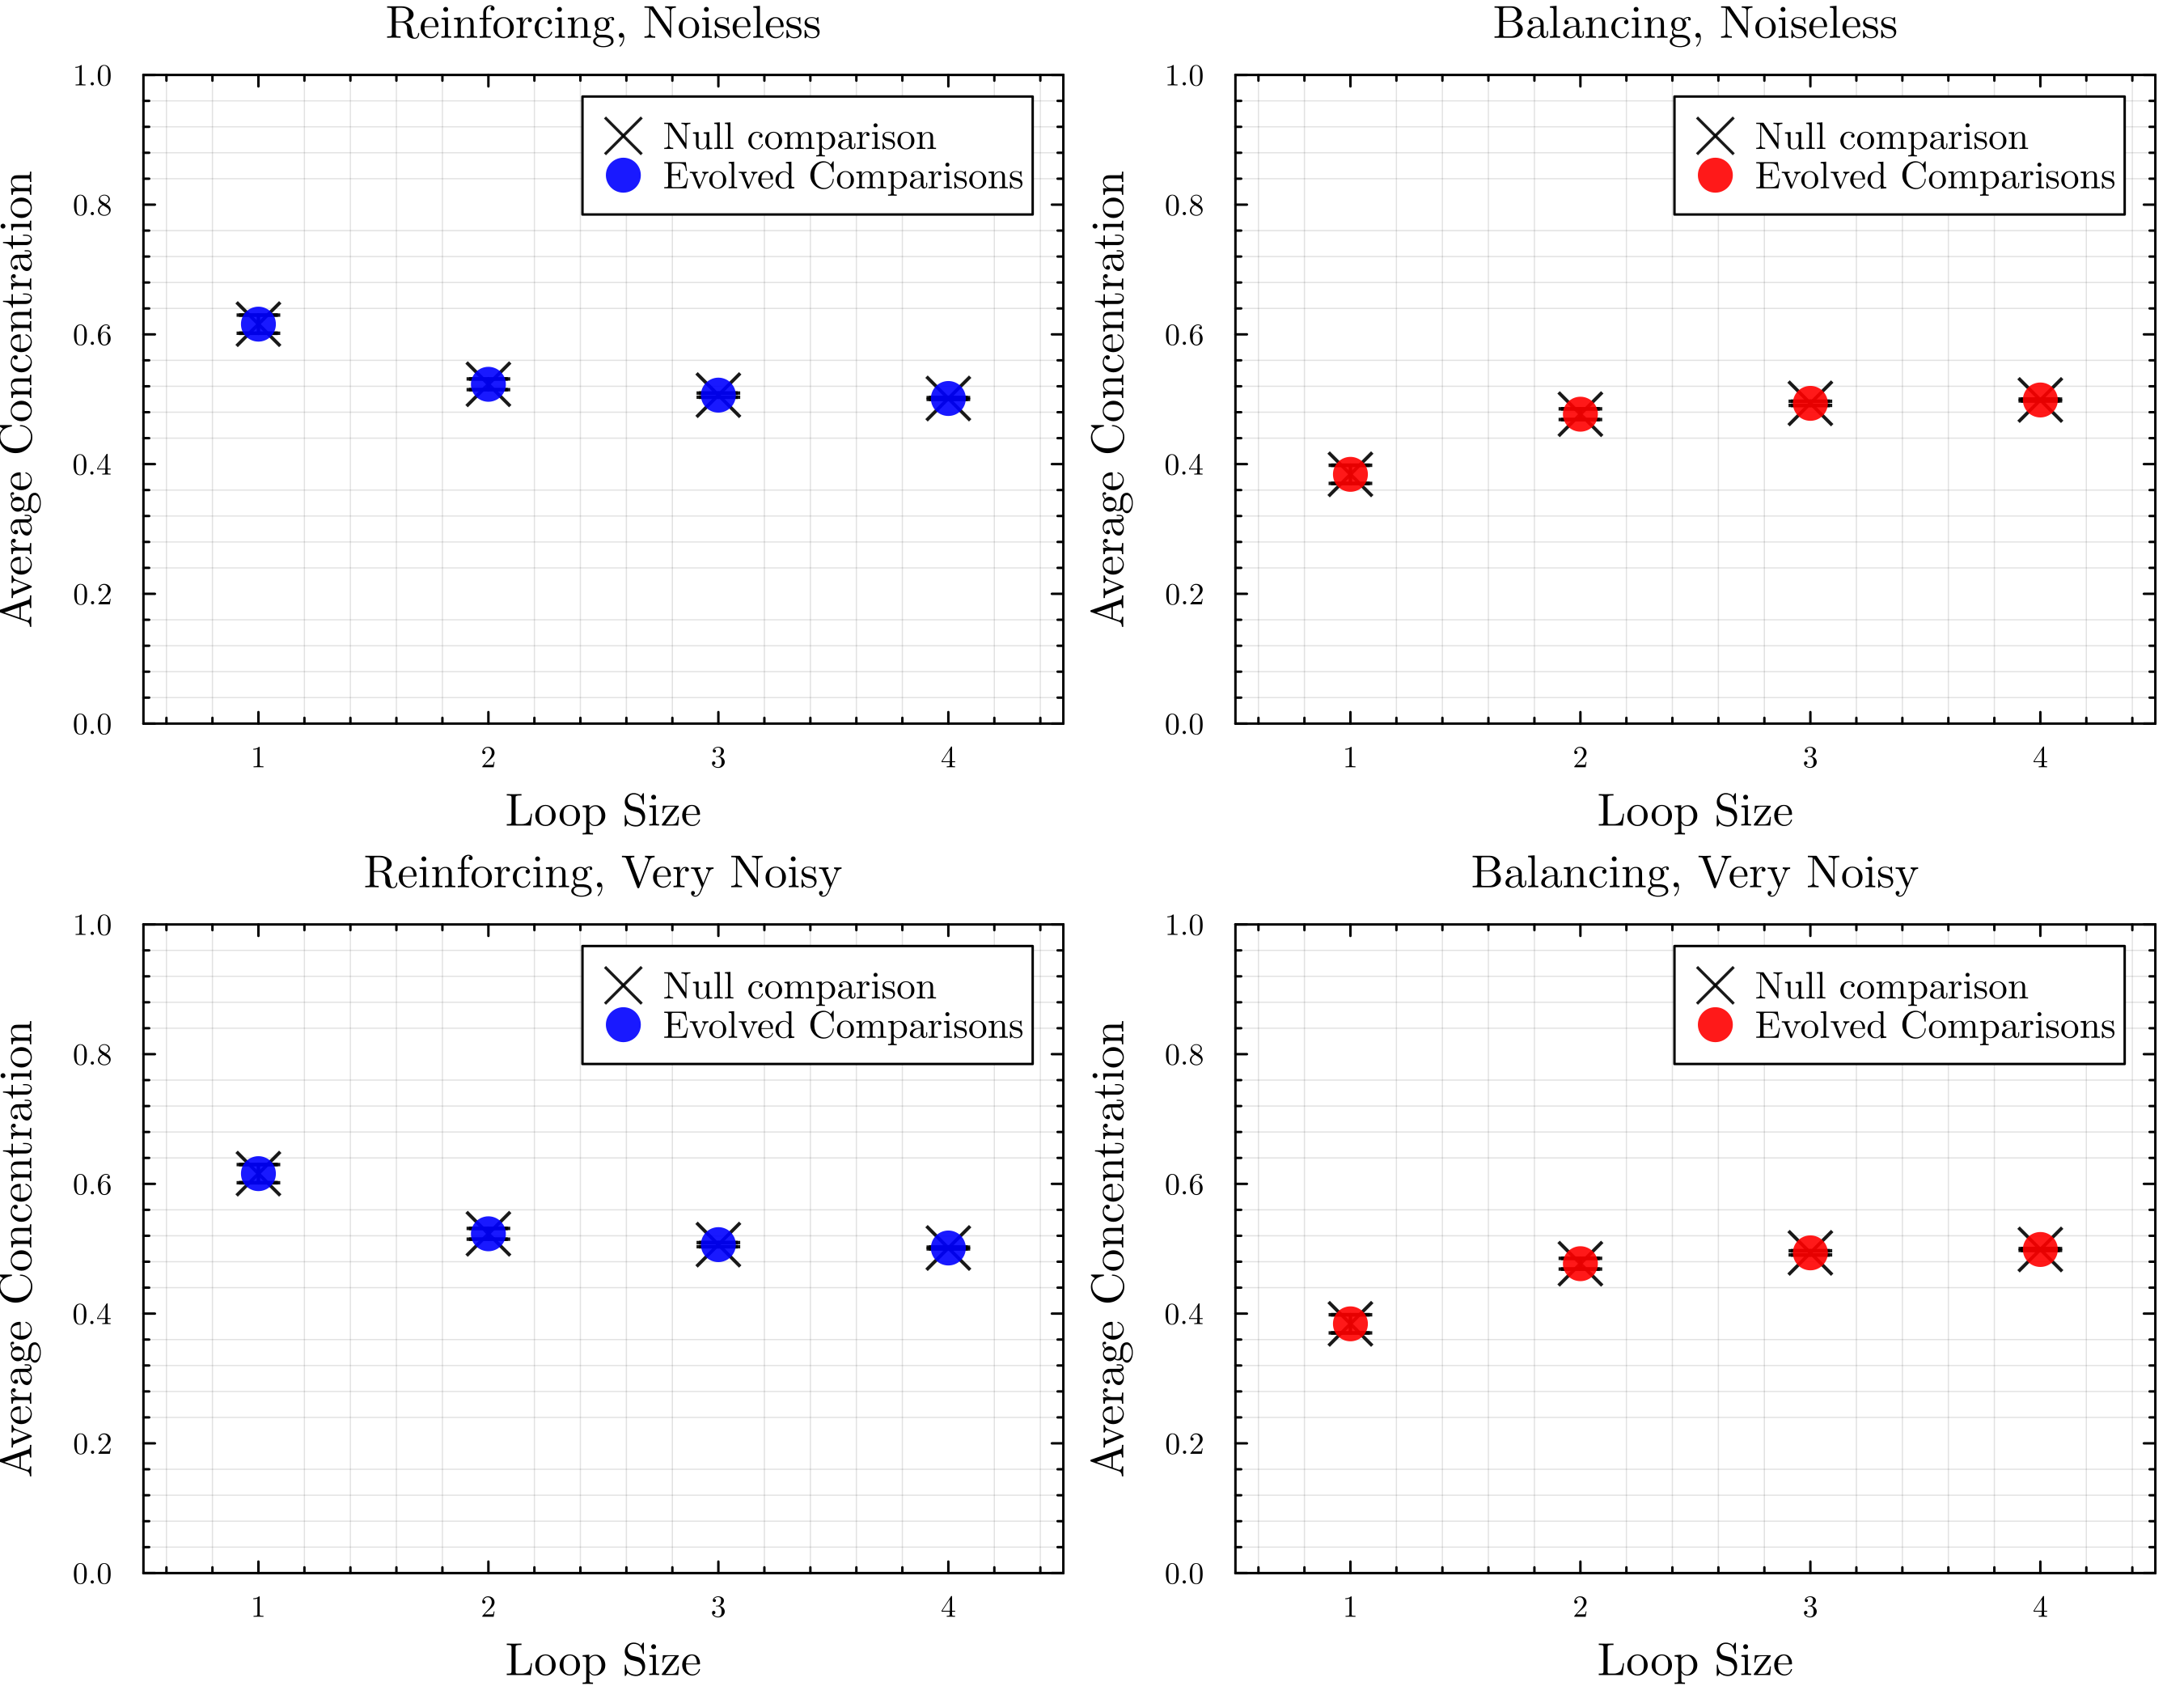

In [16]:
p1 = create_summary_plots_fbcks(expectations_noiseless_fbcks_reinf,
    expectations_random_fbcks_reinf,
    "Reinforcing, Noiseless"; max_size=4, savepath="", color=:blue)

p2 = create_summary_plots_fbcks(expectations_noiseless_fbcks_balanc,
    expectations_random_fbcks_balanc,
    "Balancing, Noiseless"; max_size=4, savepath="", color=:red)

p3 = create_summary_plots_fbcks(expectations_noisy_fbcks_reinf,
    expectations_noiseless_fbcks_reinf,
    "Reinforcing, Very Noisy"; max_size=4, savepath="", color=:blue)

p4 = create_summary_plots_fbcks(expectations_noisy_fbcks_balanc,
    expectations_noiseless_fbcks_balanc,
    "Balancing, Very Noisy"; max_size=4, savepath="", color=:red)


final_plot = plot(p1, p2, p3, p4; layout=(2,2), size=(900,700))

savefig(final_plot, "concentrations_fbcks")
display(final_plot)